![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 20 - CNN Architectures</center>
### <center> ResNet</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/IntroductionToMachineLearning/20_CNN_Architectures/MainResNet1.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 16})

In [4]:
import torch
import torchvision
import torchsummary

For Colab users:

In [5]:
!wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/IntroductionToMachineLearning/20_CNN_Architectures/ResNetExampleAux.py

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [6]:
#-- Record figures during training:
from ResNetExampleAux import Plot, Recorder, TrainLoop, ValidationLoop, TrainModel, LearningRateSweep, OneCycleScheduler

### Download CIFAR-10 dataset:

In [7]:
import torchvision
import torchvision.transforms as transforms

oTrainSet = torchvision.datasets.CIFAR10(root='../../data', train=True,  download=True, transform=transforms.ToTensor())
oTestSet  = torchvision.datasets.CIFAR10(root='../../data', train=False, download=True, transform=transforms.ToTensor())
oTrainSet.data.shape, oTrainSet[0][0].shape

Files already downloaded and verified
Files already downloaded and verified


((50000, 32, 32, 3), torch.Size([3, 32, 32]))

### Compute mean and variance:

In [8]:
vMean = oTrainSet.data.mean((0,1,2)) / 255
vStd  = oTrainSet.data.std ((0,1,2)) / 255
print('µ =', vMean)
print('σ =', vStd)

µ = [0.49139968 0.48215841 0.44653091]
σ = [0.24703223 0.24348513 0.26158784]


### Set datasets with normalization:

In [9]:
oTransform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(vMean, vStd)
])

oTrainSet = torchvision.datasets.CIFAR10(root='../../data', train=True,  transform=oTransform)
oTestSet  = torchvision.datasets.CIFAR10(root='../../data', train=False, transform=oTransform)

lClasses  = oTrainSet.classes
lClasses

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

### Plot some examples:

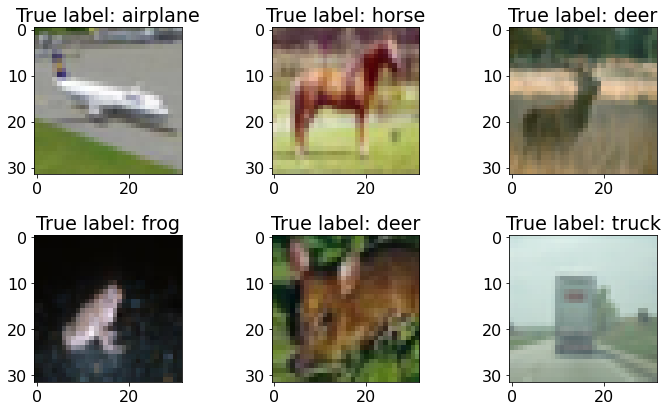

In [10]:
N, H, W, C = oTrainSet.data.shape
fig, _     = plt.subplots(2, 3, figsize=(10,6))
for ax in fig.axes:
    idx   = np.random.randint(0, N)
    mX, y = oTrainSet[idx]
    mX    = mX * vStd[:,None,None] + vMean[:,None,None] #-- unnormalizing
    mX    = torch.clamp(mX, 0, 1)
    ax.imshow(np.transpose(mX.numpy(), (1,2,0)), cmap='gray')
    ax.set_title('True label: ' + str(lClasses[y]))
    
plt.tight_layout()
plt.show()

### Create data loaders:

In [11]:
batchSize = 128
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize,   num_workers=2)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, num_workers=2)

### Define the model (2D CNN):

In [12]:
import torch.nn as nn

def LeftBranch(C):
    oModel = nn.Sequential(
        nn.Conv2d(C, C, 3, padding=1, bias=False),
        nn.BatchNorm2d(C),
        nn.ReLU(),
        nn.Conv2d(C, C, 3, padding=1, bias=False),
        nn.BatchNorm2d(C),
    )
    
    return oModel
               
def RightBranch(C):
    oModel = nn.Sequential() #-- Identity

    return oModel

In [13]:
class ResBlock(nn.Module):
    def __init__(self, C):
        super(ResBlock, self).__init__()
        
        self.oLeftBranch  = LeftBranch(C)
        self.oRightBranch = RightBranch(C)

    def forward(self, mX):
        mZ = nn.functional.relu(self.oLeftBranch(mX) + self.oRightBranch(mX))
        return mZ
        
torchsummary.summary(ResBlock(64), (64, 56, 56)); print()

------------------------------------------------------------------------------------------
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 56, 56]          --
|    └─Conv2d: 2-1                       [-1, 64, 56, 56]          36,864
|    └─BatchNorm2d: 2-2                  [-1, 64, 56, 56]          128
|    └─ReLU: 2-3                         [-1, 64, 56, 56]          --
|    └─Conv2d: 2-4                       [-1, 64, 56, 56]          36,864
|    └─BatchNorm2d: 2-5                  [-1, 64, 56, 56]          128
├─Sequential: 1-2                        [-1, 64, 56, 56]          --
Total params: 73,984
Trainable params: 73,984
Non-trainable params: 0
Total mult-adds (M): 231.28
------------------------------------------------------------------------------------------
Input size (MB): 0.77
Forward/backward pass size (MB): 6.12
Params size (MB): 0.28
Estimated Total Size (MB): 7.17
------------------------------

In [14]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data)

#-- Tensor to vector (reshape):
class Flatten(nn.Module):
    def forward(self, mX):
        N  = mX.shape[0]
        mZ = mX.view(N, -1)
        return mZ

#-- Just for the summary (identity):
class InputLayer(nn.Sequential):
    pass

    
#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
def GetModel():
    d      = 90
    oModel = nn.Sequential(
        InputLayer(),
        nn.Conv2d(3, d, 3, padding=1, bias=False), nn.BatchNorm2d(d),  nn.ReLU(),
        nn.Conv2d(d, d, 3, padding=1, bias=False), nn.BatchNorm2d(d),  nn.ReLU(),  nn.MaxPool2d(2),
        ResBlock(d),
        ResBlock(d),
        ResBlock(d),
        ResBlock(d),
        ResBlock(d),
        ResBlock(d),
        ResBlock(d),
        ResBlock(d),
        ResBlock(d),
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(d, 10)
    )
    
    oModel.apply(weights_init)
    
    return oModel


torchsummary.summary(GetModel(), (3, 32, 32)); print()

------------------------------------------------------------------------------------------
Layer (type:depth-idx)                   Output Shape              Param #
├─InputLayer: 1-1                        [-1, 3, 32, 32]           --
├─Conv2d: 1-2                            [-1, 90, 32, 32]          2,430
├─BatchNorm2d: 1-3                       [-1, 90, 32, 32]          180
├─ReLU: 1-4                              [-1, 90, 32, 32]          --
├─Conv2d: 1-5                            [-1, 90, 32, 32]          72,900
├─BatchNorm2d: 1-6                       [-1, 90, 32, 32]          180
├─ReLU: 1-7                              [-1, 90, 32, 32]          --
├─MaxPool2d: 1-8                         [-1, 90, 16, 16]          --
├─ResBlock: 1-9                          [-1, 90, 16, 16]          --
|    └─Sequential: 2-1                   [-1, 90, 16, 16]          --
|    |    └─Conv2d: 3-1                  [-1, 90, 16, 16]          72,900
|    |    └─BatchNorm2d: 3-2             [-1, 90, 1

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
device

device(type='cuda', index=0)

In [16]:
import torch.optim as optim
LossFunc = nn.CrossEntropyLoss()

###  Search learning rate:

<IPython.core.display.Javascript object>


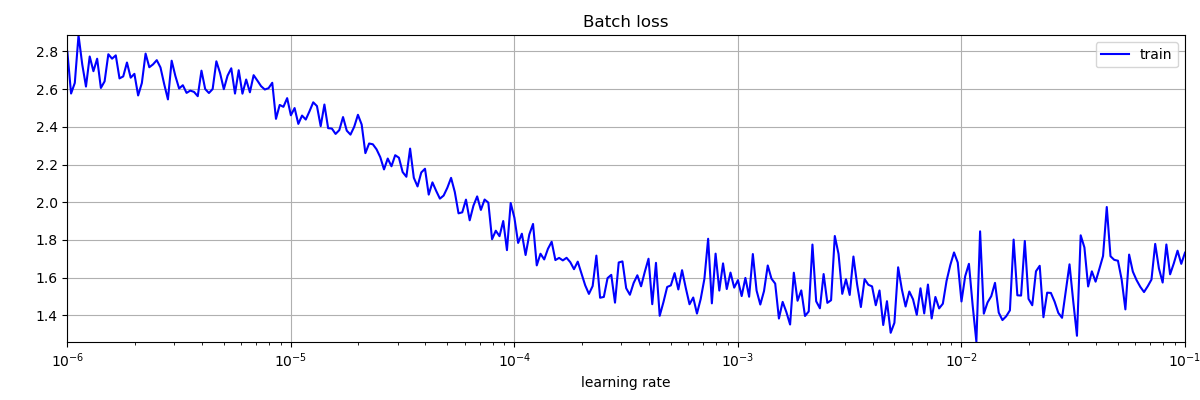

In [17]:
%matplotlib notebook
#-- Colab users should use `inline`
# %matplotlib inline

oModel        = GetModel().to(device)
oOptim        = optim.AdamW(oModel.parameters(), lr=0.1, betas=(0.9, 0.99), weight_decay=1e-4)
vLearningRate = np.logspace(-6, -1, 301)
oRecorder     = LearningRateSweep(oModel, oTrainDL, LossFunc, oOptim, vLearningRate)

For Colab users:

In [ ]:
%matplotlib inline
oRecorder.fig

<IPython.core.display.Javascript object>


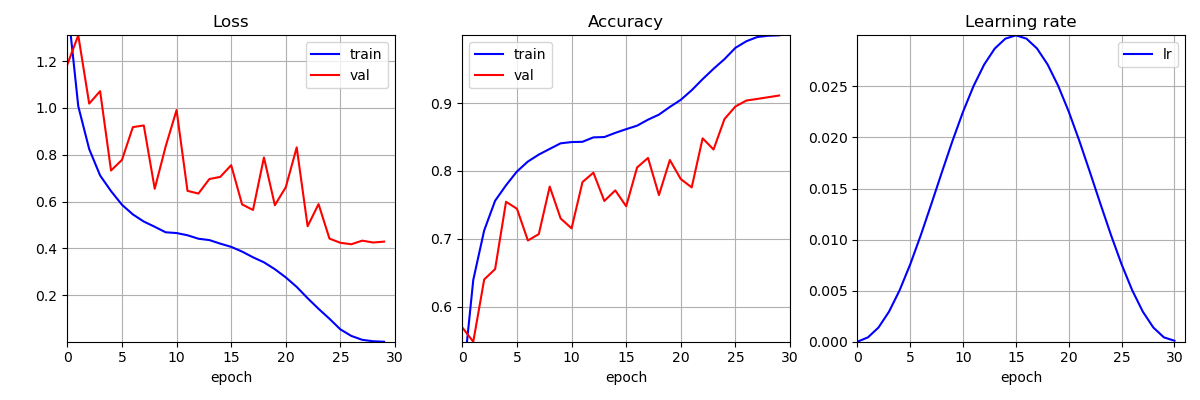

Epoch   0: | Train loss: 1.44878 | Val loss: 1.18607 | Train Accuracy: 0.4810 | Val Accuracy: 0.5690 | epoch time: 49.931 | <-- Checkpoint!
Epoch   1: | Train loss: 1.00749 | Val loss: 1.31038 | Train Accuracy: 0.6392 | Val Accuracy: 0.5481 | epoch time: 49.567 |
Epoch   2: | Train loss: 0.82462 | Val loss: 1.01874 | Train Accuracy: 0.7123 | Val Accuracy: 0.6399 | epoch time: 49.787 | <-- Checkpoint!
Epoch   3: | Train loss: 0.71171 | Val loss: 1.07189 | Train Accuracy: 0.7560 | Val Accuracy: 0.6552 | epoch time: 49.865 | <-- Checkpoint!
Epoch   4: | Train loss: 0.64486 | Val loss: 0.73292 | Train Accuracy: 0.7788 | Val Accuracy: 0.7545 | epoch time: 48.905 | <-- Checkpoint!
Epoch   5: | Train loss: 0.58661 | Val loss: 0.77826 | Train Accuracy: 0.7992 | Val Accuracy: 0.7442 | epoch time: 48.735 |
Epoch   6: | Train loss: 0.54524 | Val loss: 0.91829 | Train Accuracy: 0.8138 | Val Accuracy: 0.6974 | epoch time: 49.310 |
Epoch   7: | Train loss: 0.51486 | Val loss: 0.92538 | Train Accurac

In [18]:
%matplotlib notebook

oModel = GetModel().to(device)
oOptim = optim.AdamW(oModel.parameters(), lr=0, betas=(0.9, 0.99), weight_decay=2e-2)

iterPerEpoch  = len(oTrainDL)
numEpochs     = 30
numIter       = numEpochs * iterPerEpoch
minLR         = 1e-4
maxLR         = 3e-2
vLearningRate = minLR + .5 * (maxLR - minLR) * (1 + np.cos(np.arange(numIter) / numIter * 2*np.pi + np.pi))

oScheduler = OneCycleScheduler(oOptim, vLearningRate)
TrainModel(oModel, oTrainDL, oTestDL, LossFunc, numEpochs, oOptim, oScheduler)